In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import interpolate
from scipy.integrate import simpson
from matplotlib.widgets import Slider
from tqdm import tqdm

import src
from src.nc4.BJDSprialScan import processExpSprialScans, NC4SpiralScan

%load_ext autoreload
%autoreload 2

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [7]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [3]:
expLabels = [
    'Test 5',
    'Test 7',
    'Test 8',
    'Test 9',
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
]

exps = [src.load(label) for label in expLabels]

In [4]:
for exp in exps:
    print(exp)
    # print(exp.features.head())
    print()

Test No: 5
Date: 2022-08-03
Data: ..\..\AE\Testing\22_08_03_grit1000
No. Files: AE-213 NC4-214

Test No: 7
Date: 2022-11-07
Data: ..\..\AE\Testing\22_11_07_weartest_1000
No. Files: AE-163 NC4-164

Test No: 8
Date: 2022-11-09
Data: ..\..\AE\Testing\22_11_09_weartest_1000
No. Files: AE-176 NC4-177

Test No: 9
Date: 2022-11-30
Data: ..\..\AE\Testing\22_11_30_weartest_1000
No. Files: AE-158 NC4-159

Test No: 11
Date: 2024-05-28
Data: ..\..\AE\Testing\24_05_28_weartest_D1.3#1000
No. Files: AE-139 NC4-140

Test No: 14
Date: 2024-06-10
Data: ..\..\AE\Testing\24_06_10_weartest_D1.3_#1000
No. Files: AE-125 NC4-126

Test No: 15
Date: 2024-06-19
Data: ..\..\AE\Testing\24_06_19_weartest_D1.3_#1000
No. Files: AE-141 NC4-142

Test No: 16
Date: 2024-07-03
Data: ..\..\AE\Testing\24_07_03_weartest_D1.3_#1000
No. Files: AE-141 NC4-142

Test No: 17
Date: 2024-07-24
Data: ..\..\AE\Testing\24_07_24_weartest_D1.3_#1000
No. Files: AE-139 NC4-140

Test No: 18
Date: 2024-07-31
Data: ..\..\AE\Testing\24_07_31_w

Test No: 5
Date: 2022-08-03
Data: ..\..\AE\Testing\22_08_03_grit1000
No. Files: AE-213 NC4-214
Test No: 7
Date: 2022-11-07
Data: ..\..\AE\Testing\22_11_07_weartest_1000
No. Files: AE-163 NC4-164
Test No: 8
Date: 2022-11-09
Data: ..\..\AE\Testing\22_11_09_weartest_1000
No. Files: AE-176 NC4-177
Test No: 9
Date: 2022-11-30
Data: ..\..\AE\Testing\22_11_30_weartest_1000
No. Files: AE-158 NC4-159
Test No: 11
Date: 2024-05-28
Data: ..\..\AE\Testing\24_05_28_weartest_D1.3#1000
No. Files: AE-139 NC4-140


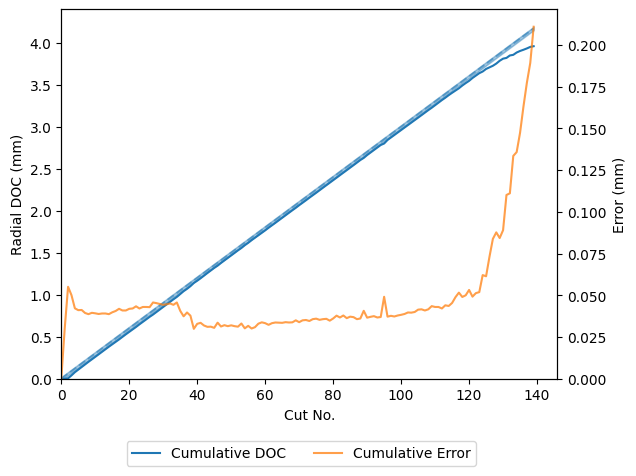

Test No: 14
Date: 2024-06-10
Data: ..\..\AE\Testing\24_06_10_weartest_D1.3_#1000
No. Files: AE-125 NC4-126


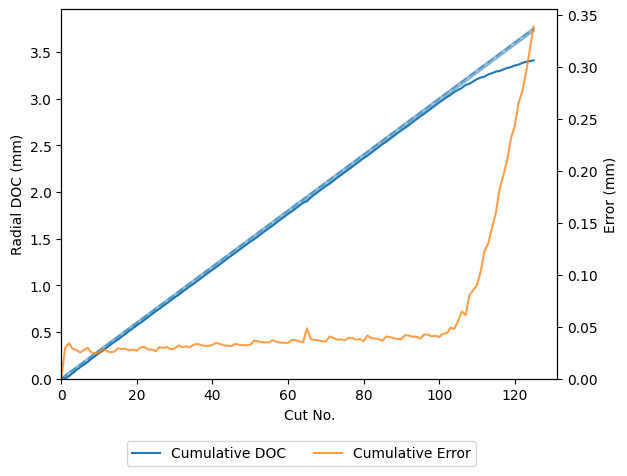

Test No: 15
Date: 2024-06-19
Data: ..\..\AE\Testing\24_06_19_weartest_D1.3_#1000
No. Files: AE-141 NC4-142


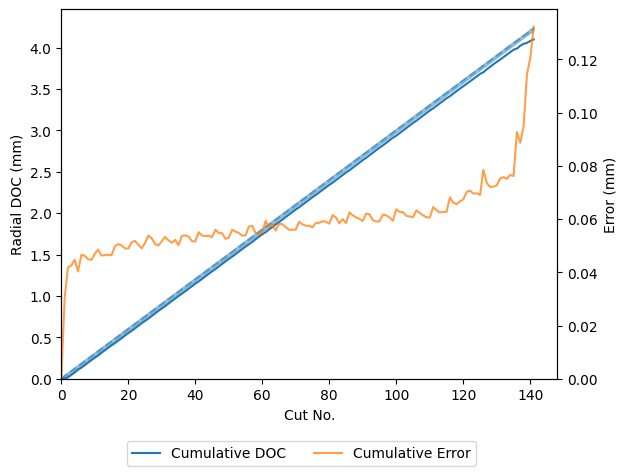

Test No: 16
Date: 2024-07-03
Data: ..\..\AE\Testing\24_07_03_weartest_D1.3_#1000
No. Files: AE-141 NC4-142


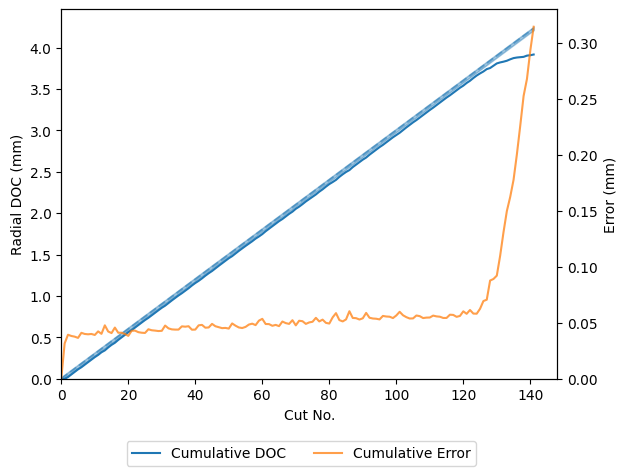

Test No: 17
Date: 2024-07-24
Data: ..\..\AE\Testing\24_07_24_weartest_D1.3_#1000
No. Files: AE-139 NC4-140


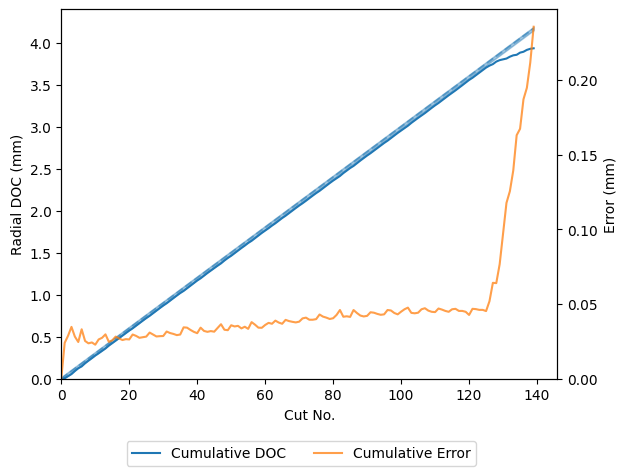

Test No: 18
Date: 2024-07-31
Data: ..\..\AE\Testing\24_07_31_weartest_D1.3_#1000
No. Files: AE-135 NC4-136


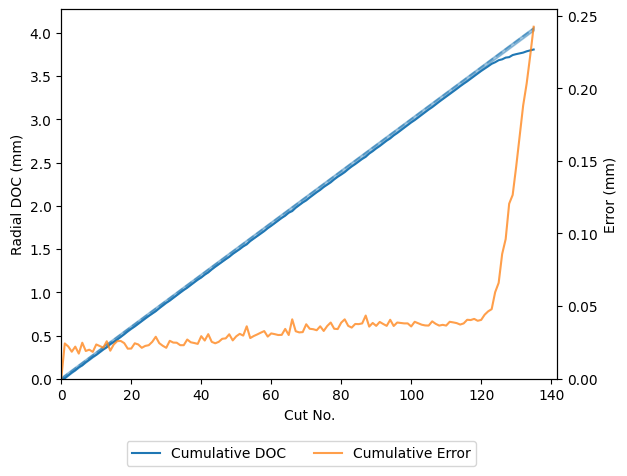

In [5]:
# If exp has probe data plot it
for exp in exps:
    print(exp)
    if exp.probe is not None:
        exp.probe.plot_probe_DOC()
        plt.show()

### NC4 - Spiral Scans

In [12]:
NOM_DIA = 1.3
FEEDRATE = 2
RPM = 60
FS = 50_000
YOFFSET = 0.03
CALFEEDRATE = 60

SCPath = CODE_DIR.joinpath(
    r'src/reference/NC4_BJD_SCurve_2024_05_30_14_17_12-Ch0-50kHz.tdms'
)
assert SCPath.exists(), "SCurve calibration file not found."

In [13]:
expSprialScans = []
for exp in exps[5:]:
    expSprialScans.append(processExpSprialScans(
        exp,
        SCPath,
        NOM_DIA,
        FEEDRATE,
        RPM,
        FS,
        YOFFSET,
        CALFEEDRATE,
    ))

Processing Spiral Scans: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


In [14]:
exp_sprial_mean = []
for exp_sc in expSprialScans:
    mean_rad = []
    for sc in exp_sc:
        z = np.arange(0, len(sc.scanMat)) * FEEDRATE / 60
        z_lower_ix = np.argmin(np.abs(z - 1.0))
        z_upper_ix = np.argmin(np.abs(z - 5))
        sc_data = sc.scanMat[z_lower_ix:z_upper_ix, :].flatten()
        sc_data = _smooth(sc_data, win=121)

        
        mean_rad.append(np.median(sc_data))
    exp_sprial_mean.append(mean_rad)

102
104
104
114
128
119


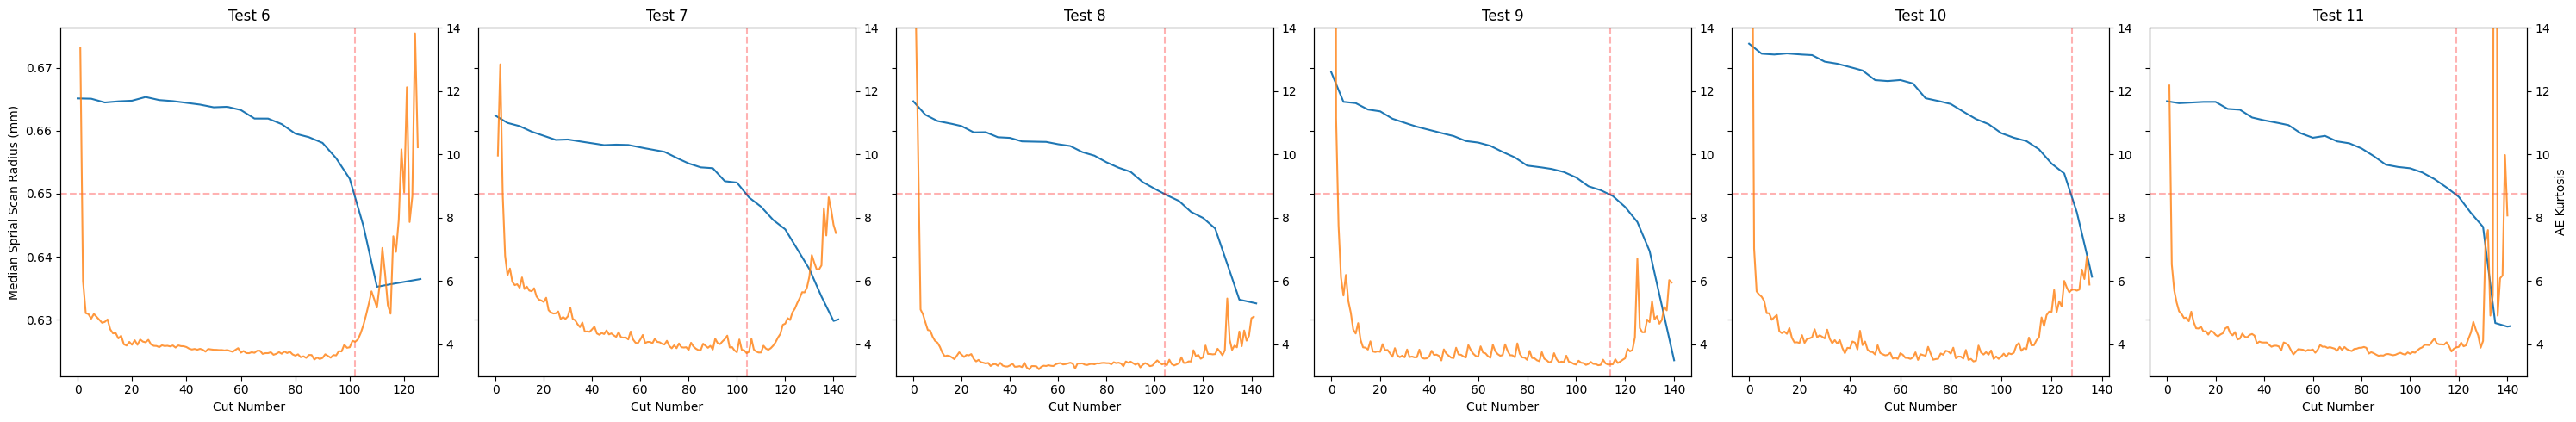

In [15]:
trig_idx = []

fig, ax = plt.subplots(1, len(exp_sprial_mean), figsize=(len(exp_sprial_mean) * 5, 5), sharey=True)
for i, c in enumerate(exp_sprial_mean):
    x = np.arange(0, len(c)) * 5
    f = interpolate.interp1d(x, c, fill_value='extrapolate')

    xnew = np.arange(0, len(exps[i+5].features['Kurtosis']) + 1)
    ynew = f(xnew)

    # ax[i].plot(x, c)
    ax[i].plot(xnew, ynew)
    ax[i].set_title(f"Test {i+6}")

    trig = 0.65
    ax[i].axhline(trig, color='r', linestyle='--', alpha=0.3)
    idx = np.where(np.array(ynew) < trig)[0][0]
    print(idx) 
    ax[i].axvline(idx, color='r', linestyle='--', alpha=0.3)
    trig_idx.append(idx)

    ax2 = ax[i].twinx()
    ax2.plot(exps[i+5].features['Kurtosis'], color='C1', alpha=0.8)
    ax2.set_ylim(3, 14)

    ax[i].set_xlabel('Cut Number')
    ax[0].set_ylabel('Median Sprial Scan Radius (mm)')
ax2.set_ylabel('AE Kurtosis')

fig.tight_layout()

## PROBE VS AE

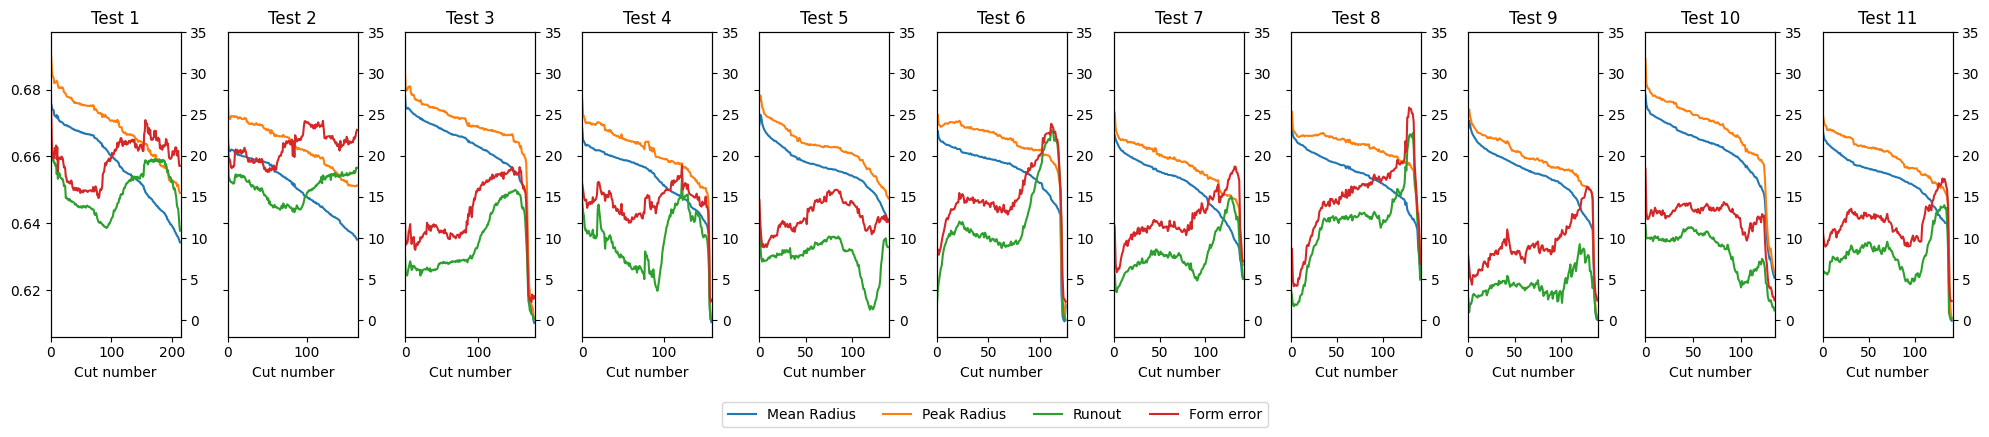

In [4]:
fig, ax = plt.subplots(1, len(exps), figsize=(5 * 4, 4), sharey=True)
for i, exp in enumerate(exps):
    ax[i].plot(exp.features['Mean radius'], label='Mean Radius')
    ax[i].plot(exp.features['Peak radius'], label='Peak Radius')
    ax2 = ax[i].twinx()
    ax2.plot(exp.features['Runout'] * 1000, 'C2', label='Runout')
    ax2.plot(exp.features['Form error'] * 1000, 'C3', label='Form error')
    ax[i].set_xlim(0, len(exp.features))
    ax2.set_ylim(-2, 35)

    ax[i].set_title(f"Test {i + 1}")
    ax[i].set_xlabel('Cut number')

# ax[0].set_ylabel(f'AE Feature - {feat}')
# ax2.set_ylabel('Probed DOC (um)')
l1, lab1 = ax[-1].get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()

fig.legend(l1 + l2, lab1 + lab2, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

fig.tight_layout()

(2.0, 15.0)

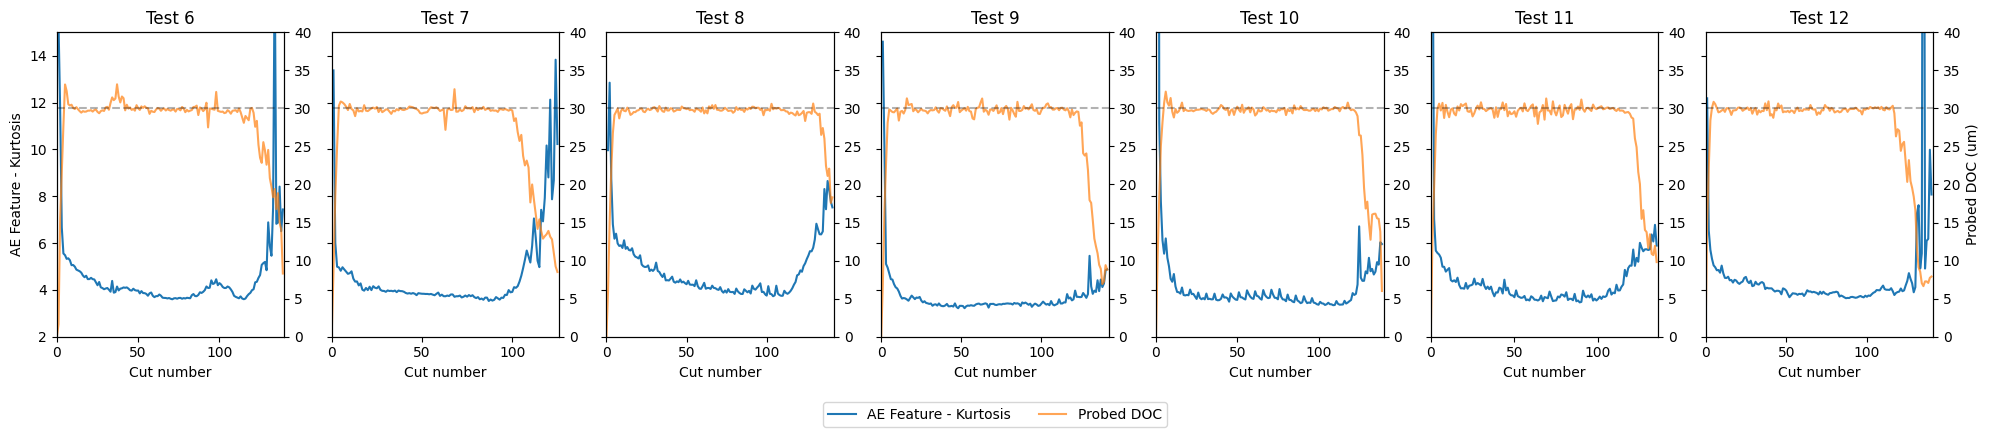

In [8]:
def plotProbeVSAEFeat(feat):
    _exps = exps[4:]
    fig, ax = plt.subplots(1, len(_exps), figsize=(5 * 4, 4), sharey=True)
    for i, exp in enumerate(_exps):
        ax[i].plot(exp.features[feat], label=f'AE Feature - {feat}')
        if exp.probe is not None:
            ax2 = ax[i].twinx()
            ax2.plot(_smooth(exp.features['Probe diff'] * 1000, 5), 'C1', alpha=0.7, label='Probed DOC')
            ax2.axhline(exp.probe.doc * 1000, color='k', linestyle='--', alpha=0.3)
            ax2.set_ylim(0, 40)
        ax[i].set_xlim(0, len(exp.features))

        ax[i].set_title(f"Test {i + 6}")
        ax[i].set_xlabel('Cut number')

    ax[0].set_ylabel(f'AE Feature - {feat}')
    ax2.set_ylabel('Probed DOC (um)')

    l1 = ax[-1].get_lines()[0]
    l2 = ax2.get_lines()[0]
    lab1 = l1.get_label()
    lab2 = l2.get_label()
    fig.legend([l1, l2], [lab1, lab2], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    fig.tight_layout()
    return fig, ax

feat = 'Kurtosis'
fig, ax = plotProbeVSAEFeat(feat)
# for _ax, ix in zip(ax[5:], trig_idx):
#     _ax.axvline(ix, color='r', linestyle='--', alpha=0.3)
ax[0].set_ylim(2, 15)

In [ ]:
for i, st_i in enumerate(np.arange(0, 1_000, 10)):
    print(f'Bin {i} - {st_i} to {st_i + 10} kHz')


Bin 0 - 0 to 10 kHz
Bin 1 - 10 to 20 kHz
Bin 2 - 20 to 30 kHz
Bin 3 - 30 to 40 kHz
Bin 4 - 40 to 50 kHz
Bin 5 - 50 to 60 kHz
Bin 6 - 60 to 70 kHz
Bin 7 - 70 to 80 kHz
Bin 8 - 80 to 90 kHz
Bin 9 - 90 to 100 kHz
Bin 10 - 100 to 110 kHz
Bin 11 - 110 to 120 kHz
Bin 12 - 120 to 130 kHz
Bin 13 - 130 to 140 kHz
Bin 14 - 140 to 150 kHz
Bin 15 - 150 to 160 kHz
Bin 16 - 160 to 170 kHz
Bin 17 - 170 to 180 kHz
Bin 18 - 180 to 190 kHz
Bin 19 - 190 to 200 kHz
Bin 20 - 200 to 210 kHz
Bin 21 - 210 to 220 kHz
Bin 22 - 220 to 230 kHz
Bin 23 - 230 to 240 kHz
Bin 24 - 240 to 250 kHz
Bin 25 - 250 to 260 kHz
Bin 26 - 260 to 270 kHz
Bin 27 - 270 to 280 kHz
Bin 28 - 280 to 290 kHz
Bin 29 - 290 to 300 kHz
Bin 30 - 300 to 310 kHz
Bin 31 - 310 to 320 kHz
Bin 32 - 320 to 330 kHz
Bin 33 - 330 to 340 kHz
Bin 34 - 340 to 350 kHz
Bin 35 - 350 to 360 kHz
Bin 36 - 360 to 370 kHz
Bin 37 - 370 to 380 kHz
Bin 38 - 380 to 390 kHz
Bin 39 - 390 to 400 kHz
Bin 40 - 400 to 410 kHz
Bin 41 - 410 to 420 kHz
Bin 42 - 420 to 430 kH

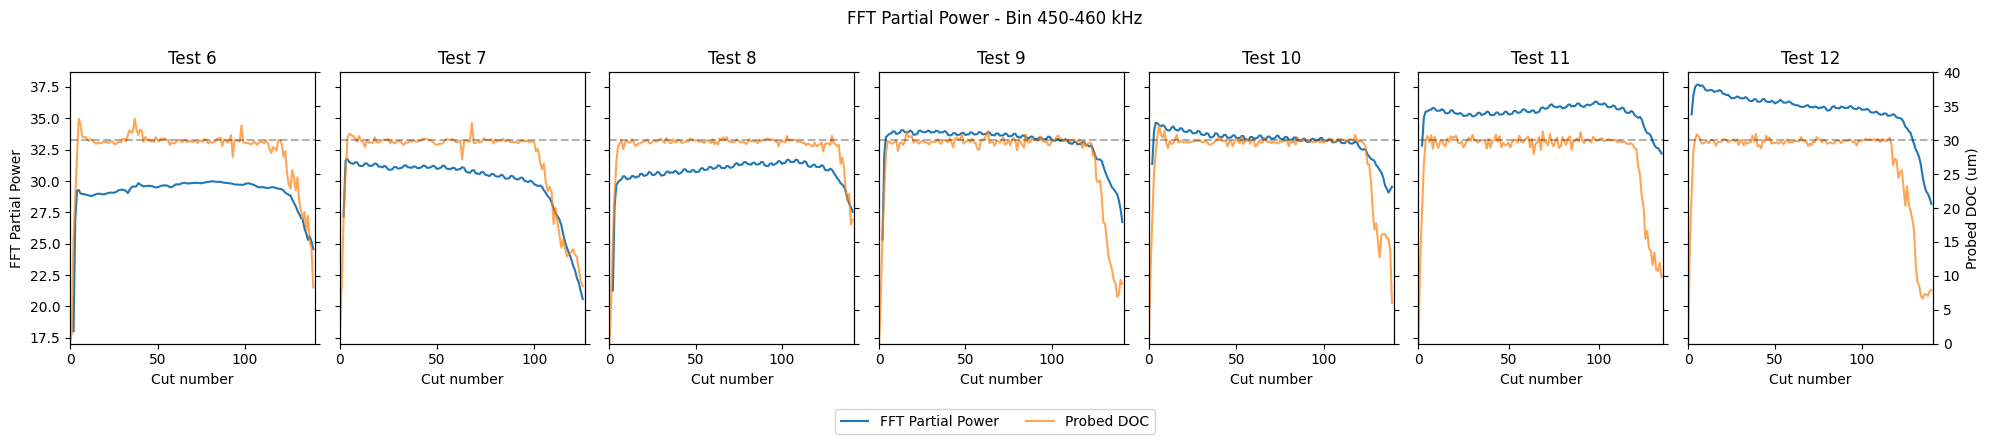

In [9]:
def plotProbeVSFFT(freq):
    _exps = exps[4:]
    fig, ax = plt.subplots(1, len(_exps), figsize=(5 * 4, 4), sharey=True)
    for i, exp in enumerate(_exps):
        f = np.array(exp.ae.fft[1000])
        # avg over 10kHz
        f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
        f = f.T
        f = np.concatenate(([np.NaN], f[freq]))

        ax[i].plot(_smooth(f, 3), label=f'FFT Partial Power')
        if exp.probe is not None:
            ax2 = ax[i].twinx()
            ax2.plot(_smooth(exp.features['Probe diff'] * 1000, 5), 'C1', alpha=0.7, label='Probed DOC')
            ax2.axhline(exp.probe.doc * 1000, color='k', linestyle='--', alpha=0.3)
            ax2.set_ylim(0, 40)
        ax[i].set_xlim(0, len(exp.features))

        ax[i].set_title(f"Test {i + 6}")
        ax[i].set_xlabel('Cut number')
        if i != len(_exps) - 1:
            ax2.set_yticklabels([])

    ax[0].set_ylabel(f'FFT Partial Power')
    ax2.set_ylabel('Probed DOC (um)')

    l1 = ax[-1].get_lines()[0]
    l2 = ax2.get_lines()[0]
    lab1 = l1.get_label()
    lab2 = l2.get_label()
    fig.legend([l1, l2], [lab1, lab2], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    fig.tight_layout()
    return fig, ax

freq = 45
fig, ax = plotProbeVSFFT(freq)
fig.suptitle(f'FFT Partial Power - Bin {freq * 10}-{(freq*10) + 10} kHz')
# for _ax, ix in zip(ax[5:], trig_idx):
#     _ax.axvline(ix, color='r', linestyle='--', alpha=0.3)
fig.tight_layout()

Max correlation: 0.815 at 910 kHz
Max correlation: 0.873 at 440 kHz
Max correlation: 0.810 at 910 kHz
Max correlation: 0.832 at 810 kHz
Max correlation: 0.851 at 810 kHz
Max correlation: 0.806 at 470 kHz
Max correlation: 0.877 at 330 kHz


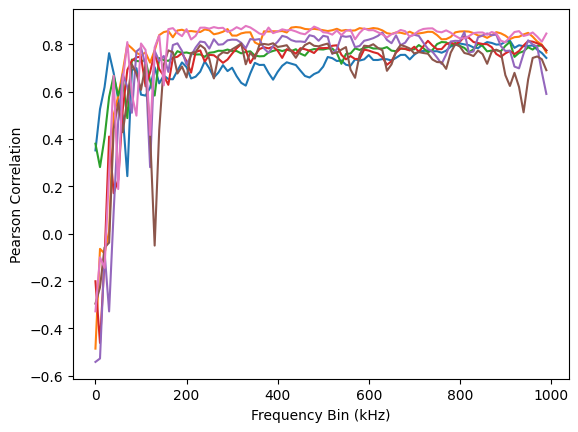

In [11]:
_exps = exps[4:]
fig, ax = plt.subplots()
for exp in _exps:
    # correlation between frequency bins and probe data
    f = np.array(exp.ae.fft[1000])
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T
    p = exp.probe.probeData['PROBEDIFF'][1:]
    fbin = np.arange(0, 1_000, 10)
    c = np.corrcoef(f, p)

    ax.plot(fbin, c[-1, :-1])
    ax.set_ylabel('Pearson Correlation')
    ax.set_xlabel('Frequency Bin (kHz)')

    # max correlation

    max_corr = np.max(c[-1, :-1])
    max_corr_ix = np.argmax(c[-1, :-1])

    print(f'Max correlation: {max_corr:.3f} at {max_corr_ix * 10} kHz')
